
## Jupyter Notebook: Support Vector Machine (SVM) Example - Breast Cancer Classification

**Goal:** To classify breast tumors as malignant (cancerous) or benign (non-cancerous) using features derived from digitized images of fine-needle aspirate (FNA) tests.

**SVM Intuition:** SVM is a powerful supervised learning algorithm used for classification and regression. For classification, the core idea is to find the optimal "hyperplane" (a line in 2D, a plane in 3D, or a hyperplane in higher dimensions) that best separates the data points belonging to different classes in the feature space. The "best" hyperplane is the one with the maximum margin – the largest distance between the hyperplane and the nearest data points (called support vectors) from each class. SVMs can also use "kernels" (like RBF, polynomial, sigmoid) to effectively handle non-linearly separable data by mapping it into a higher-dimensional space where separation might become linear.

---

### 1. Import Libraries

We'll need libraries for data handling, modeling, scaling, and evaluation.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Dataset loading, splitting
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# SVM Classifier
from sklearn.svm import SVC # "SVC" stands for Support Vector Classifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


---

### 2. Load and Explore the Dataset

We'll use the Breast Cancer Wisconsin dataset, available in scikit-learn. It contains 30 numeric features computed from digitized images of breast mass FNA tests.

In [2]:
# Load the dataset
cancer = load_breast_cancer()

# Create a Pandas DataFrame
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target # 0: malignant, 1: benign
cancer_df['target_name'] = cancer_df['target'].map({0: 'malignant', 1: 'benign'})

# Display first few rows
print("First 5 rows of the Breast Cancer dataset:")
print(cancer_df.head())

# Display basic info
print("\nDataset Info:")
cancer_df.info()

# Display summary statistics (notice the wide range in values - scaling will be important!)
print("\nSummary Statistics:")
# Increase display precision for clarity
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(cancer_df.describe())

# Check class balance (how many malignant vs. benign cases)
print("\nClass Distribution:")
print(cancer_df['target_name'].value_counts())

First 5 rows of the Breast Cancer dataset:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst perimeter  

*Observation:* The dataset has 569 samples and 30 features. There are more benign cases (357) than malignant (212). Critically, notice the large differences in the scale of features (e.g., 'mean area' vs. 'mean smoothness'). This highlights the need for feature scaling, especially for distance-sensitive algorithms like SVM.

---

### 3. Prepare Data for Modeling

Separate features (X) and target (y), then split into training and testing sets.

In [3]:
# Features (independent variables)
X = cancer.data # cancer_df.iloc[:, :-2] # Using the numpy array directly

# Target variable (dependent variable)
y = cancer.target # cancer_df['target']

# Split data into training and testing sets (e.g., 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# random_state for reproducibility, stratify to maintain class proportions

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape:  X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(426, 30), y_train=(426,)
Testing set shape:  X_test=(143, 30), y_test=(143,)


---

### 4. Feature Scaling (Crucial for SVM)

SVMs are sensitive to the scale of features because the algorithm works by finding distances between points to define the margin. Features with larger values can disproportionately influence the distance calculation. We'll use `StandardScaler` to standardize features (mean=0, variance=1).

**Important:** Fit the scaler *only* on the training data to prevent data leakage from the test set, then transform *both* the training and test sets.

In [4]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the SAME fitted scaler
X_test_scaled = scaler.transform(X_test)

# Display the effect of scaling on the first few samples (optional)
print("\nOriginal Training Data (First Sample):\n", X_train[0][:5]) # Show first 5 features
print("\nScaled Training Data (First Sample):\n", X_train_scaled[0][:5])
print("\nScaled Test Data (First Sample):\n", X_test_scaled[0][:5])


Original Training Data (First Sample):
 [1.989e+01 2.026e+01 1.305e+02 1.214e+03 1.037e-01]

Scaled Training Data (First Sample):
 [1.65909581 0.21720545 1.6106199  1.63333853 0.57631161]

Scaled Test Data (First Sample):
 [-0.37811061 -0.58413032 -0.37600132 -0.45097608  1.23648301]


---

### 5. Build and Train the SVM Model

We'll create an `SVC` instance. Common kernel choices are `'linear'`, `'poly'`, and `'rbf'` (Radial Basis Function, often a good default). Key hyperparameters include:
* `C`: Regularization parameter. Controls the trade-off between achieving a low training error and a low testing error (generalization). Smaller C creates a wider margin but tolerates more misclassifications. Larger C aims for fewer misclassifications on the training data, potentially leading to a narrower margin and overfitting.
* `gamma`: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. Defines how far the influence of a single training example reaches. Low values mean 'far', high values mean 'close'.

Let's start with the default RBF kernel and default parameters (`C=1.0`, `gamma='scale'`).

In [5]:
# Create the SVM classifier instance (using default RBF kernel)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42) # random_state for reproducibility if algorithm has stochastic elements

# Train the model using the SCALED training data
svm_model.fit(X_train_scaled, y_train)

print("\nSVM model trained successfully with RBF kernel.")


SVM model trained successfully with RBF kernel.


---

### 6. Make Predictions

Use the trained SVM model to make predictions on the *scaled* test data.

In [6]:
# Predict the classes for the SCALED test data
y_pred = svm_model.predict(X_test_scaled)

# Display sample predictions vs actual
print("\nSample Predictions vs Actual Labels:")
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df['Actual_Name'] = comparison_df['Actual'].map({0: 'malignant', 1: 'benign'})
comparison_df['Predicted_Name'] = comparison_df['Predicted'].map({0: 'malignant', 1: 'benign'})
print(comparison_df[['Actual_Name', 'Predicted_Name']].head(10))


Sample Predictions vs Actual Labels:
  Actual_Name Predicted_Name
0      benign         benign
1   malignant      malignant
2      benign         benign
3      benign         benign
4   malignant      malignant
5   malignant      malignant
6   malignant      malignant
7   malignant      malignant
8   malignant      malignant
9      benign         benign


---

### 7. Evaluate the Model

Assess the performance using standard classification metrics.


Model Accuracy: 0.9790

Confusion Matrix:
Labels: {0: np.str_('malignant'), 1: np.str_('benign')}
[[52  1]
 [ 2 88]]


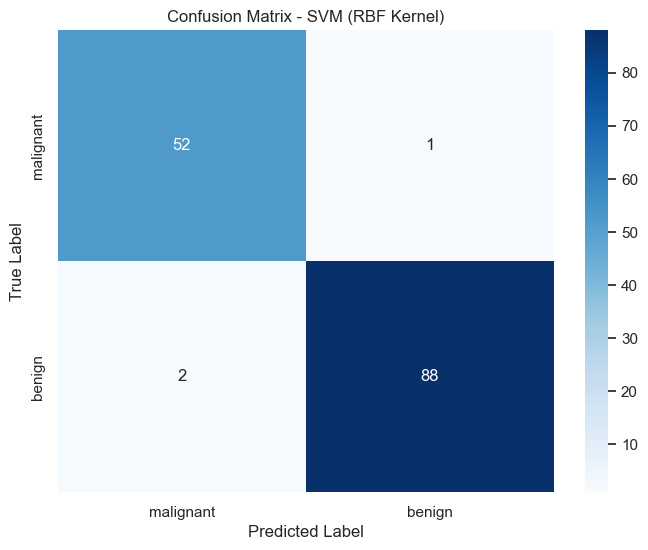


Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        53
      benign       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [7]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
# Rows: True class, Columns: Predicted class
# [[True Malignant (TN)], [False Benign (FP)]]
# [[False Malignant(FN)], [True Benign (TP)]] -> Note: Scikit-learn puts 0 (malignant) first usually
# Let's verify with labels:
target_names = cancer.target_names # ['malignant', 'benign']
print(f"Labels: {dict(enumerate(target_names))}")
print(cm)


# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM (RBF Kernel)')
plt.show()

# Generate the Classification Report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

*Interpretation Notes:*
* **Accuracy:** Very high, indicating the model performs well overall.
* **Confusion Matrix:** Shows the exact number of correct/incorrect predictions for each class. For instance, how many actual 'malignant' cases were correctly predicted as 'malignant' (True Negatives if malignant=0), and how many were incorrectly predicted as 'benign' (False Positives if malignant=0). *(Check the specific TN/FP/FN/TP mapping based on the class labels 0 and 1).*
* **Precision (Malignant):** Of all tumors predicted as malignant, how many actually were?
* **Recall (Malignant):** Of all tumors that were truly malignant, how many did the model correctly identify? This is often crucial in medical diagnosis (minimizing False Negatives - failing to detect cancer).
* **Precision/Recall (Benign):** Similar interpretations for the benign class.
* **F1-Score:** Balance between precision and recall.

The model seems to perform exceptionally well on this dataset, achieving high precision and recall for both classes.


---

### 8. Conclusion

We successfully applied the Support Vector Machine (SVM) algorithm with an RBF kernel to the Breast Cancer Wisconsin dataset. Key steps included loading the data, performing essential **feature scaling** (standardization), training the `SVC` model, making predictions, and evaluating performance. The SVM achieved high accuracy, precision, and recall, demonstrating its effectiveness for this binary classification task.

SVMs are powerful tools, particularly effective in high-dimensional spaces and versatile due to different kernel options. However, choosing the right kernel and tuning hyperparameters can be important for optimal performance, and they can be computationally intensive to train on very large datasets.